In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [21]:
train_data

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808
...,...,...,...,...
230085,2018-12-27,6,9,890
230086,2018-12-28,6,9,892
230087,2018-12-29,6,9,895
230088,2018-12-30,6,9,899


In [22]:
# Преобразуем 'Date' в формат datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Группируем по неделям и считаем суммы по 'number_sold', оставляем только 'Date' и 'number_sold'
train_aggregated = train_data.groupby(train_data['Date'].dt.to_period('W'))['number_sold'].sum()
test_aggregated = test_data.groupby(test_data['Date'].dt.to_period('W'))['number_sold'].sum()

# Получаем дату конца недели (воскресенье)
train_aggregated.index = train_aggregated.index.to_timestamp('D') + pd.Timedelta(days=6)  # Последний день недели (воскресенье)
test_aggregated.index = test_aggregated.index.to_timestamp('D') + pd.Timedelta(days=6)  # Последний день недели (воскресенье)

# Переводим индексы в формат даты и сбрасываем индекс
train_aggregated = train_aggregated.reset_index()
test_aggregated = test_aggregated.reset_index()

# Выводим результат
print(train_aggregated.head())

        Date  number_sold
0 2010-01-03       164693
1 2010-01-10       383832
2 2010-01-17       383627
3 2010-01-24       382977
4 2010-01-31       383274


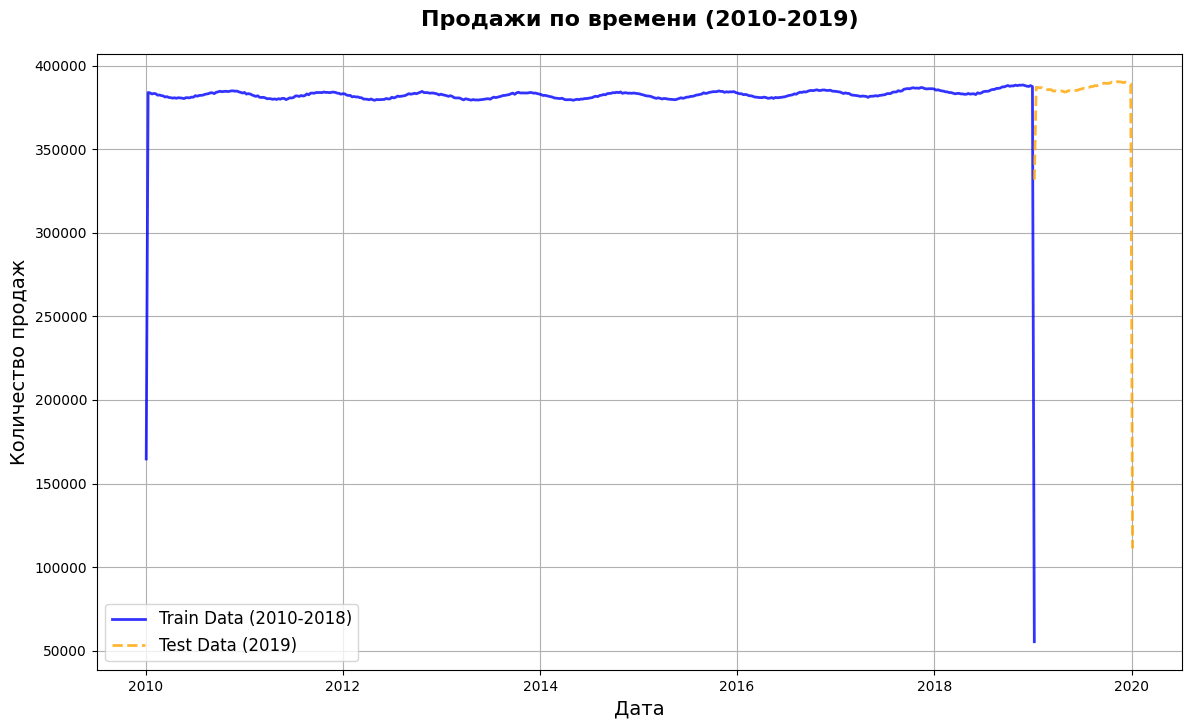

In [23]:
# Построение графика временных рядов
plt.figure(figsize=(14, 8))

plt.plot(train_aggregated['Date'], train_aggregated['number_sold'], label='Train Data (2010-2018)', linewidth=2, alpha=0.8, color='blue')
plt.plot(test_aggregated['Date'], test_aggregated['number_sold'], label='Test Data (2019)', linestyle='--', linewidth=2, alpha=0.8, color='orange')

plt.title('Продажи по времени (2010-2019)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество продаж', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

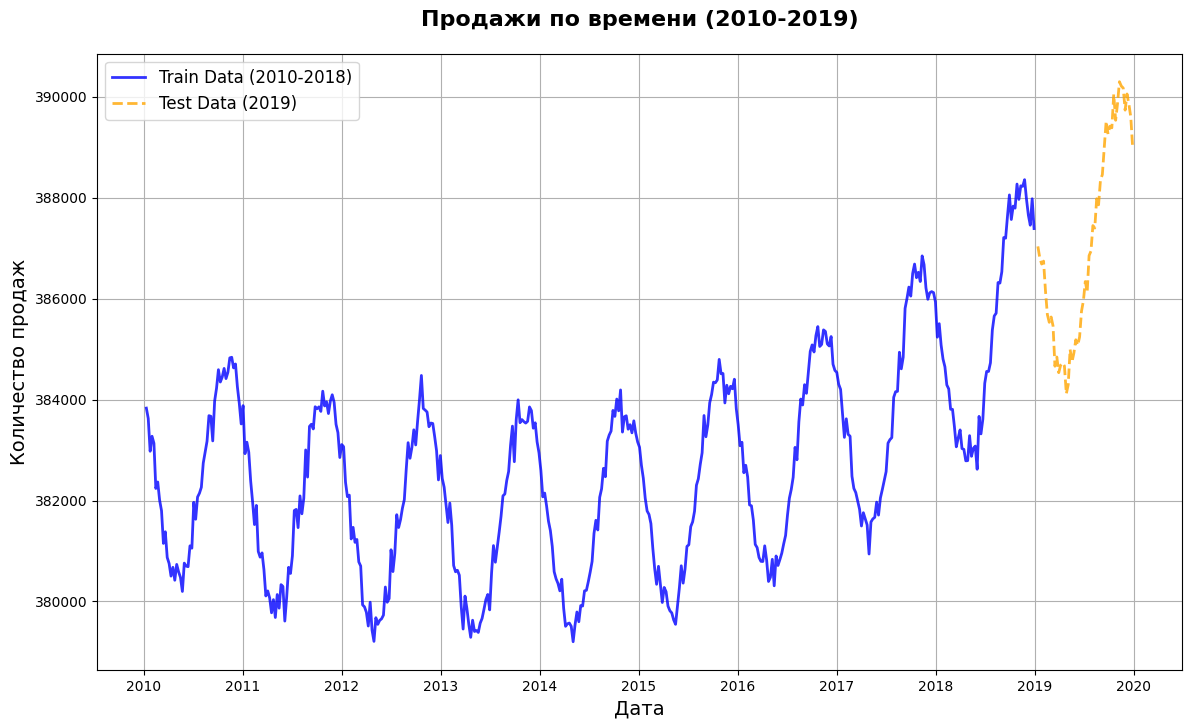

In [24]:
# Убираем выбросы
train_aggregated = train_aggregated[train_aggregated['number_sold'] >= 300000]
test_aggregated = test_aggregated[test_aggregated['number_sold'] >= 380000]

# Построение графика временных рядов
plt.figure(figsize=(14, 8))

plt.plot(train_aggregated['Date'], train_aggregated['number_sold'], label='Train Data (2010-2018)', linewidth=2, alpha=0.8, color='blue')
plt.plot(test_aggregated['Date'], test_aggregated['number_sold'], label='Test Data (2019)', linestyle='--', linewidth=2, alpha=0.8, color='orange')

plt.title('Продажи по времени (2010-2019)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество продаж', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

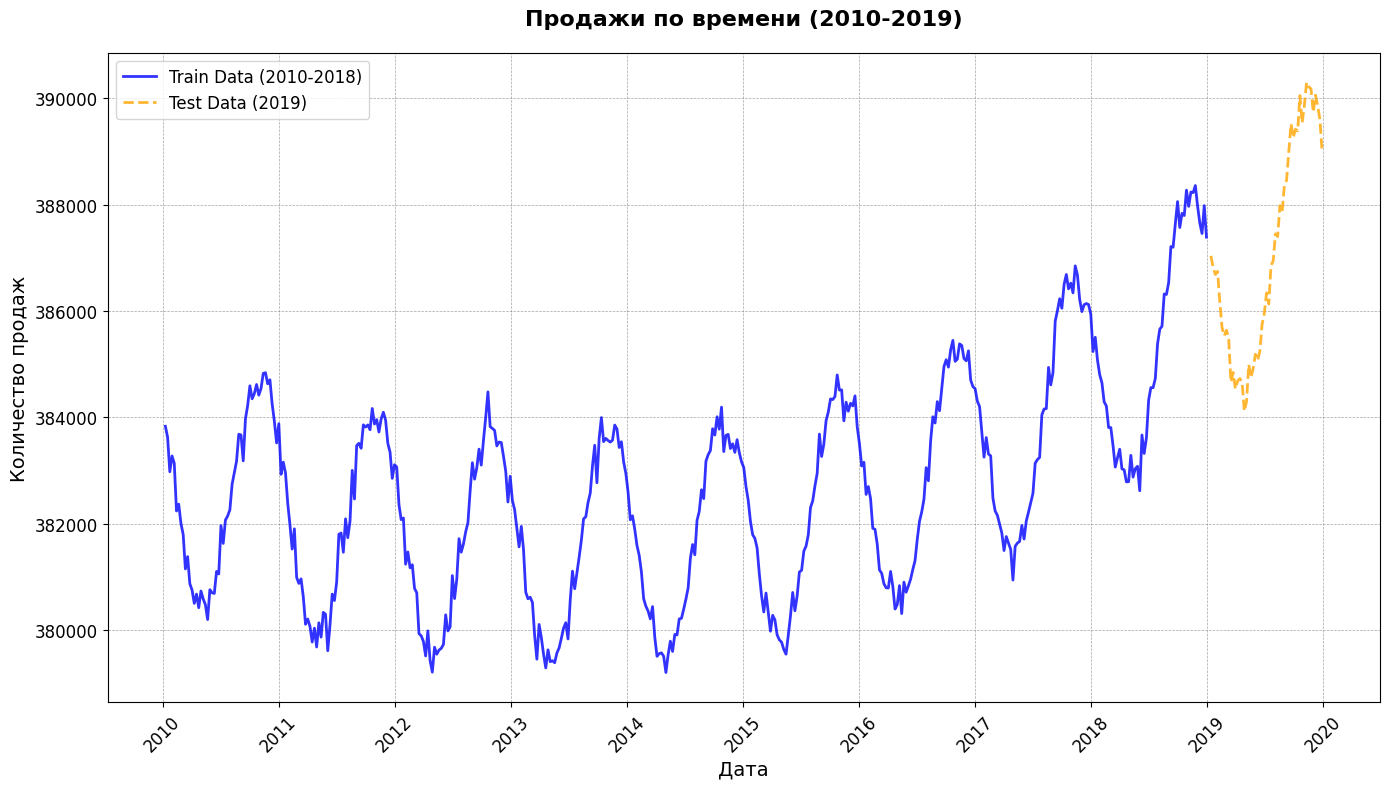

In [25]:
# Построение графика
plt.figure(figsize=(14, 8))
plt.plot(train_aggregated['Date'], train_aggregated['number_sold'], 
         label='Train Data (2010-2018)', linewidth=2, alpha=0.8, color='blue')
plt.plot(test_aggregated['Date'], test_aggregated['number_sold'], 
         label='Test Data (2019)', linestyle='--', linewidth=2, alpha=0.8, color='orange')

plt.title('Продажи по времени (2010-2019)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество продаж', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper left')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



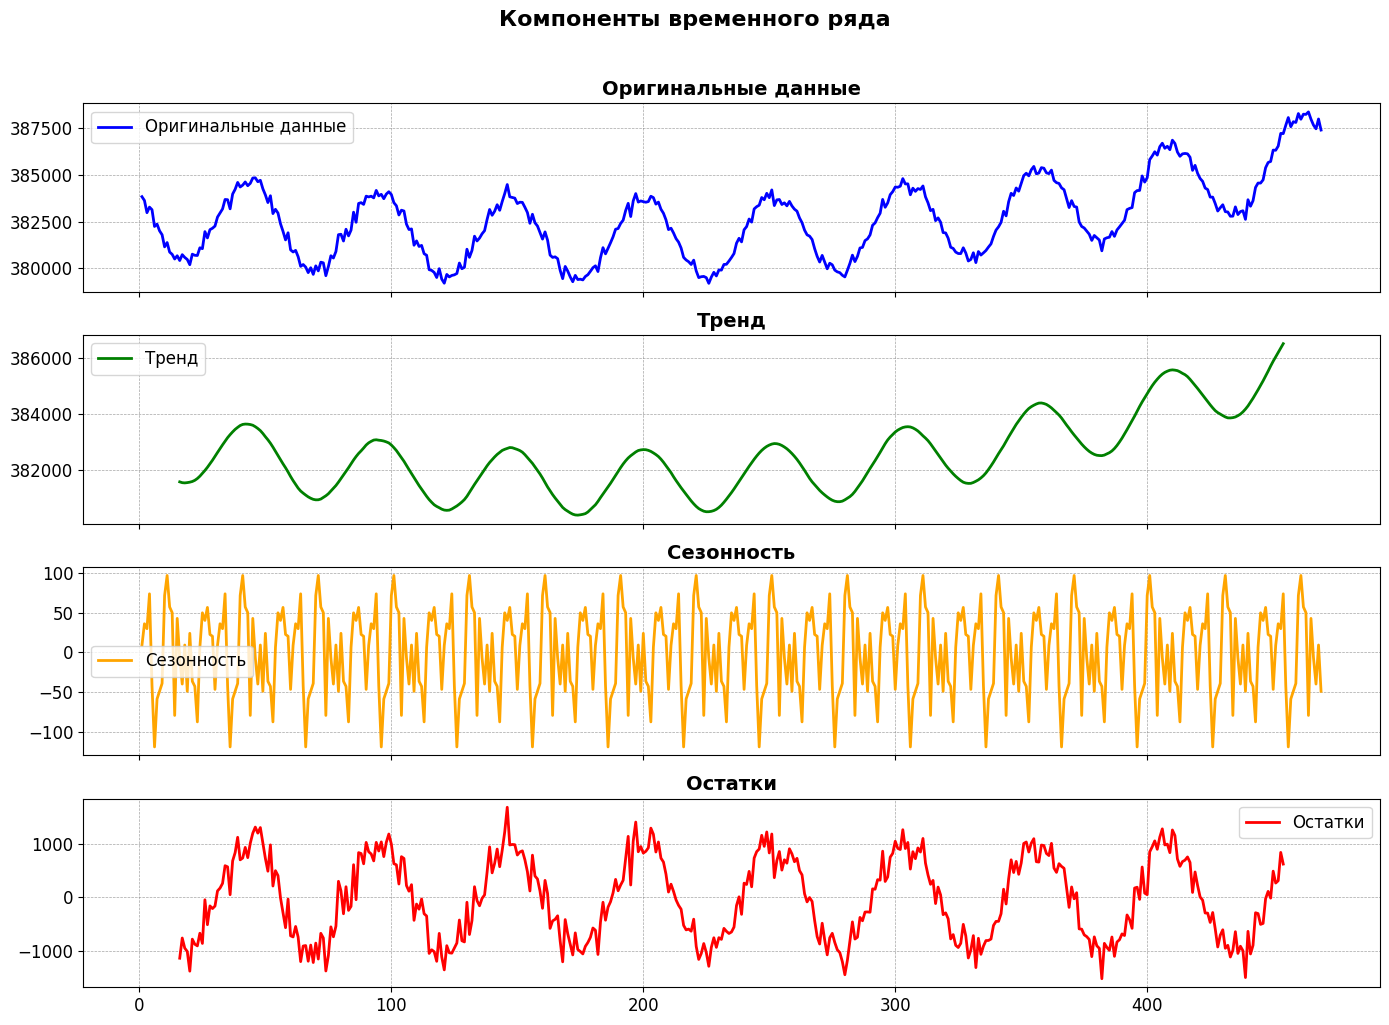

In [26]:
result = seasonal_decompose(train_aggregated['number_sold'], model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
axes[0].plot(result.observed, label='Оригинальные данные', color='blue', linewidth=2)
axes[0].set_title('Оригинальные данные', fontsize=14, fontweight='bold')
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

axes[1].plot(result.trend, label='Тренд', color='green', linewidth=2)
axes[1].set_title('Тренд', fontsize=14, fontweight='bold')
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

axes[2].plot(result.seasonal, label='Сезонность', color='orange', linewidth=2)
axes[2].set_title('Сезонность', fontsize=14, fontweight='bold')
axes[2].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

axes[3].plot(result.resid, label='Остатки', color='red', linewidth=2)
axes[3].set_title('Остатки', fontsize=14, fontweight='bold')
axes[3].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', labelsize=12)

plt.suptitle('Компоненты временного ряда', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [27]:
#Есть выраженная нестационарность ряда, нужно дифференцировать

ADF Statistic: -11.1999673740661
p-value: 2.2566658035529443e-20
Ряд является стационарным.


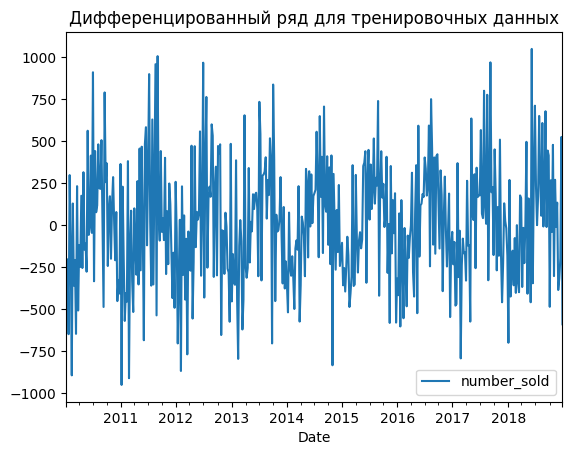

In [28]:
# Функция проверки стационарности ряда с использованием теста Дики-Фуллера
def check_stationarity(series):
    result = adfuller(series.dropna())  # Убираем NaN перед тестом
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] > 0.05:
        print("Ряд не является стационарным.")
        return False
    else:
        print("Ряд является стационарным.")
        return True

# Дифференцирование только по количествам, оставляя даты
train_st = train_aggregated[['Date', 'number_sold']].copy()
train_st['number_sold'] = train_st['number_sold'].diff()  # Дифференцируем только колонку 'number_sold'

# Проверка стационарности
check_stationarity(train_st['number_sold'])



# Визуализация
train_st.plot(x='Date', y='number_sold', title="Дифференцированный ряд для тренировочных данных")
plt.show()



In [29]:
# Проверка целостности таблиц после дифференцирования
print(train_st.columns)
print(train_st['Date'].isnull().sum()) 
print(train_st.index.isnull().sum())

# Обновление формата даты и ре-индексация
train_st['Date'] = pd.to_datetime(train_st['Date'], errors='coerce')
train_st = train_st.set_index('Date')
train_st = train_st.dropna() 

train_st

Index(['Date', 'number_sold'], dtype='object')
0
0


,number_sold
Date,
2010-01-17,-205.0
2010-01-24,-650.0
2010-01-31,297.0
2010-02-07,-139.0
2010-02-14,-895.0
...,...
2018-12-02,-387.0
2018-12-09,-317.0
2018-12-16,-198.0


In [93]:
#Обучение ARIMA

In [72]:
# Подавление предупреждений
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Задаем диапазоны для p и q (значения от 0 до 15)
p_values = q_values = range(0, 15)
parameter_combinations = list(itertools.product(p_values, q_values))

# Инициализация переменных для хранения минимального AIC и лучших параметров
lowest_aic = float('inf')  # Изначально устанавливаем очень большое значение AIC
optimal_params = None

# Перебор всех возможных комбинаций p и q
for params in parameter_combinations:
    # Добавляем d=1 для всех моделей в данном примере
    model_params = (params[0], 1, params[1])
    
    try:
        # Создание и обучение модели ARIMA с текущими параметрами
        arima_model = sm.tsa.ARIMA(train_st['number_sold'], order=model_params)
        model_fit = arima_model.fit()

        # Получение значения AIC для текущей модели
        aic_value = model_fit.aic

        # Сравнение AIC и обновление наилучших параметров
        if aic_value < lowest_aic:
            lowest_aic = aic_value
            optimal_params = model_params
    except:
        # Ошибка игнорируется и продолжается перебор с другими параметрами
        pass

# Вывод наилучших параметров и минимального AIC
print(f"Лучшие параметры: {optimal_params}, Минимальный AIC: {lowest_aic}")

Лучшие параметры: (14, 1, 14), Минимальный AIC: 6531.982014372747


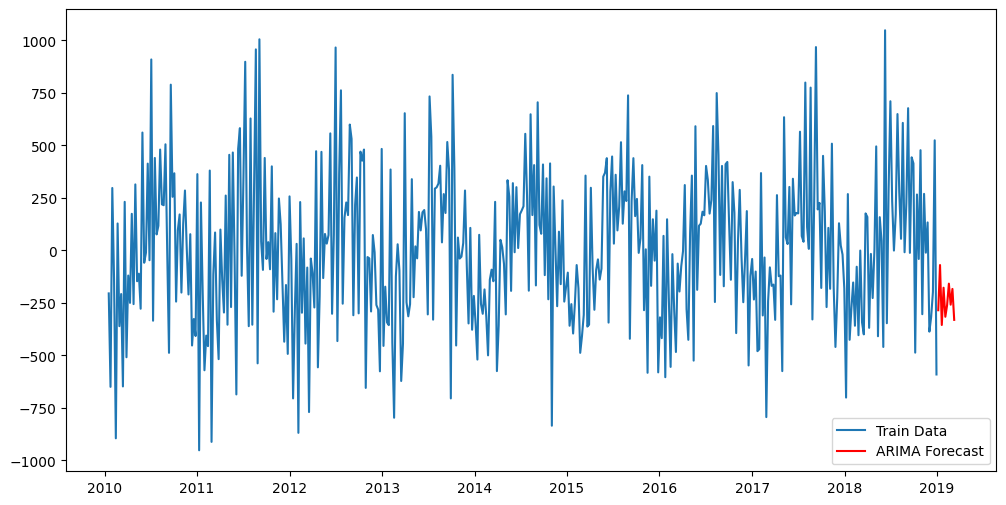

In [73]:
# Обучение модели ARIMA

# Подавление предупреждений
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

arima_model = sm.tsa.ARIMA(train_st['number_sold'], order=(30, 1, 2))
arima_fit = arima_model.fit()

# Прогнозирование
forecast_steps = 10
arima_forecast = arima_fit.forecast(steps=forecast_steps)

# Генерация прогнозных дат
forecast_index = pd.date_range(
    start=train_st.index[-1] + pd.Timedelta(days=7),
    periods=forecast_steps,
    freq='W-SUN'
)
final_model_fit = arima_model.fit()
# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(train_st.index, train_st['number_sold'], label='Train Data')
plt.plot(forecast_index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()

In [79]:
#Анализ датасетов перед сведением
print("test_aggregated index type:", type(test_aggregated.index))
print("forecast index type:", type(forecast_index))
print("test_aggregated index:", test_aggregated.index)
print("forecast index:", forecast_index)

test_aggregated index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
forecast index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
test_aggregated index: DatetimeIndex(['2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03',
               '2019-02-10', '2019-02-17', '2019-02-24', '2019-03-03',
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12', '2019-05-19', '2019-05-26',
               '2019-06-02', '2019-06-09', '2019-06-16', '2019-06-23',
               '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21',
               '2019-07-28', '2019-08-04', '2019-08-11', '2019-08-18',
               '2019-08-25', '2019-09-01', '2019-09-08', '2019-09-15',
               '2019-09-22', '2019-09-29', '2019-10-06', '2019-10-13',
               '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10',
               '2019-11-17', '2019-11-2

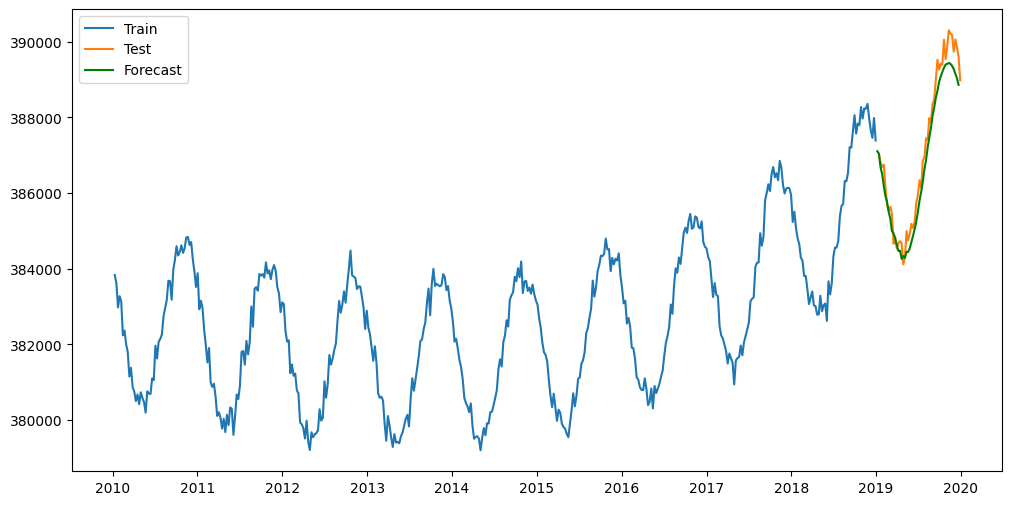

In [81]:
forecast_index = pd.date_range(start=train_aggregated.index[-1] + pd.Timedelta(weeks=1), periods=len(test_aggregated), freq='W-SUN')

# Приведение размера прогноза к длинне теста
forecast_st = final_model_fit.forecast(steps=len(test_aggregated))
#Приведение к нестационарному состоянию
forecast = forecast_st.cumsum() + train_aggregated['number_sold'].iloc[-1]


# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(train_aggregated.index, train_aggregated['number_sold'], label='Train')
plt.plot(test_aggregated.index, test_aggregated['number_sold'], label='Test')
plt.plot(forecast_index, forecast, label='Forecast', color='green')  # Используем обновленный индекс
plt.legend()
plt.show()

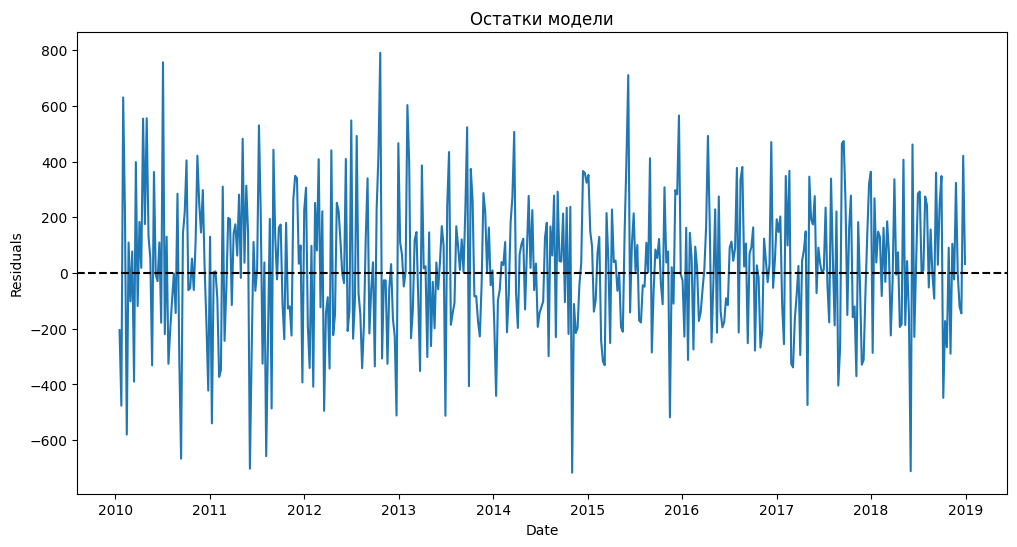

In [82]:
# Построение графика остатков
plt.figure(figsize=(12, 6))
plt.plot(final_model_fit.resid)
plt.axhline(y=0, color='black', linestyle='--')  # Горизонтальная линия на уровне 0
plt.title('Остатки модели')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [83]:
rmse = np.sqrt(mean_squared_error(test_aggregated, forecast))
mae = mean_absolute_error(test_aggregated, forecast)
r2 = r2_score(test_aggregated, forecast)

print(f"RMSE: {rmse}, MAE: {mae}, R^2: {r2} ")

RMSE: 524.3410571778128, MAE: 446.8501250203128, R^2: 0.93235212379043 


In [47]:
#Обучение SARIMA

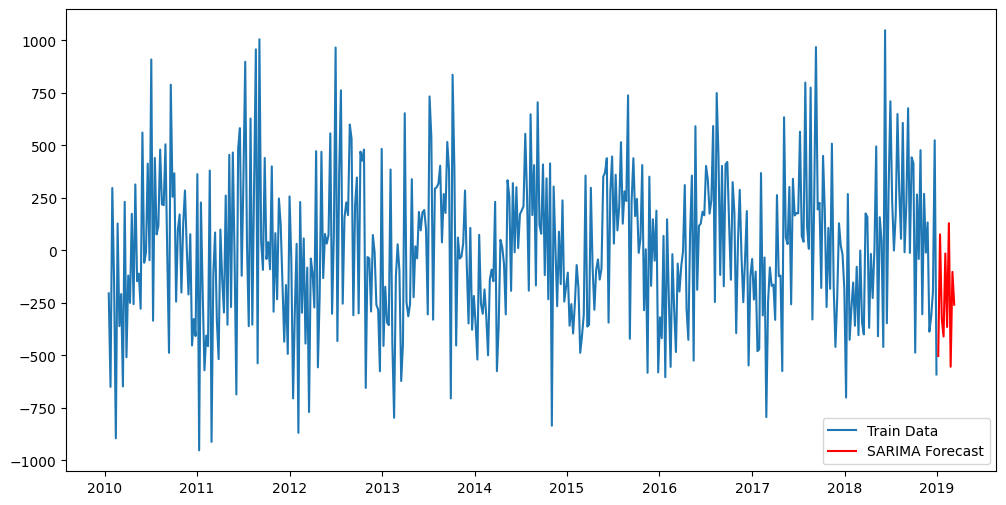

In [36]:
# Обучение модели SARIMA
# Установите частоту для индекса (например, еженедельно по воскресеньям)
train_st = train_st.asfreq('W-SUN')

# Повторите это для test_aggregated
test_aggregated.index = pd.to_datetime(test_aggregated.index)
test_aggregated = test_aggregated.asfreq('W-SUN')

# Теперь обучение модели и прогнозирование с SARIMA
sarima_model = sm.tsa.SARIMAX(train_st['number_sold'], 
                              order=(14, 1, 14),
                              seasonal_order=(1, 1, 1, 52),
                              enforce_stationarity=False, enforce_invertibility=False)

sarima_fit = sarima_model.fit(maxiter=1000)

# Прогнозирование
forecast_steps = 10
sarima_forecast = sarima_fit.forecast(steps=forecast_steps)

# Генерация прогнозных дат
forecast_index = pd.date_range(
    start=train_st.index[-1] + pd.Timedelta(days=7),
    periods=forecast_steps,
    freq='W-SUN'
)

# Построение графиков для SARIMA

plt.figure(figsize=(12, 6))
plt.plot(train_st.index, train_st['number_sold'], label='Train Data')
plt.plot(forecast_index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.legend()
plt.show()

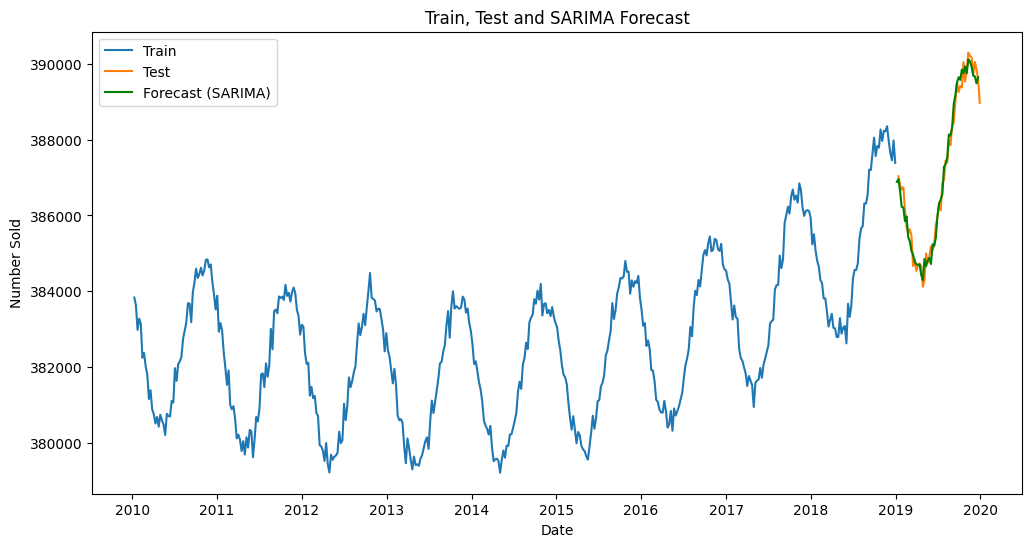

In [47]:
# Создание прогноза
forecast_index = pd.date_range(
    start=train_aggregated.index[-1] + pd.Timedelta(weeks=1),
    periods=len(test_aggregated),
    freq='W-SUN'
)
forecast_st = sarima_fit.forecast(steps=len(test_aggregated))

# Приведение прогноза к нестационарному состоянию
forecast_sarima = forecast_st.cumsum() + train_aggregated['number_sold'].iloc[-1]

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(train_aggregated.index, train_aggregated['number_sold'], label='Train')
plt.plot(test_aggregated.index, test_aggregated['number_sold'], label='Test')
plt.plot(forecast_index, forecast_sarima, label='Forecast (SARIMA)', color='green')  # SARIMA прогноз
plt.legend()
plt.title('Train, Test and SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.show()

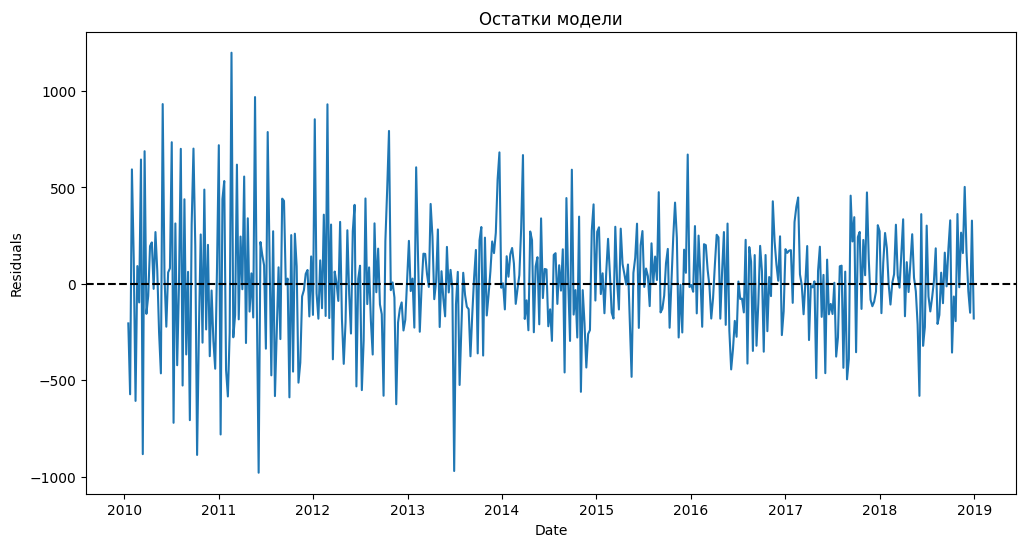

In [56]:
# Построение графика остатков
plt.figure(figsize=(12, 6))
plt.plot(sarima_fit.resid)
plt.axhline(y=0, color='black', linestyle='--')  # Горизонтальная линия на уровне 0
plt.title('Остатки модели')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [69]:
rmse = np.sqrt(mean_squared_error(test_aggregated, forecast_sarima))
mae = mean_absolute_error(test_aggregated, forecast_sarima)
r2 = r2_score(test_aggregated, forecast_sarima)

print(f"RMSE: {rmse}, MAE: {mae}, R^2: {r2} ")

RMSE: 281.46259145063965, MAE: 228.60511899203766, R^2: 0.9805074884725947 


In [71]:
#Вывод: с помощью SARIMA удалось сделать более точную модель, которая способна повторять колебания ряда с высокой точностью.
